# Atlantic and Indopacific basin averaged Merdional Overturning Circulation

Here, we compute the zonally averaged Meridional Overturning Streamfunction in density space in a similar fashion to [the global Zonally Averaged Meridional Overturning Circulation example](https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Zonally_Averaged_Global_Meridional_Overturning_Circulation.ipynb)), except that we partition the overturning circulation into the Atlantic and IndoPacific Basins. Strong NADW circulation in the Atlantic can sometimes obscure AABW circulation in the IndoPacific in fully zonally averaged plots, something we can minimise by the masking procedure below.

Note that there is an alternative masking strategy, which involves loading pre-prepared masks for each resolution from `basin_mask.nc` in (for example)  `/g/data/ik11/inputs/access-om2/input_08022019/mom_1deg`. The aim of this script is to be resolution-independent.

Compute times were calculated using the XXLarge (28 cpus, 128 Gb mem) Jupyter Lab on NCI's ARE, using conda environment analysis3-22.10

## 1. Requirements

**The cosima-cookbook**: The `conda/analysis3-20.01` (or later) module on the VDI/Gadi (or your own up-to-date cookbook installation).

**Model diagnostics**: ``ty_trans_rho``

In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from dask.distributed import Client

This is just to stop annoying warnings coming out of `xarray`.

In [2]:
import warnings
warnings.filterwarnings('ignore')

You should also set up a dask client. The easiest way to do this is shown here. 

Once you've set up a dask-worker, connect to it, click the dashboard link to check worker status

In [3]:
client = Client("tcp://10.6.22.43:8786")
client

<Client: 'tcp://10.6.22.43:8786' processes=1 threads=48, memory=188.56 GiB>

You need to nominate a database - I'm just using the default one here.

Now, let's nominate an experiment. **This script is designed to be robust to resolution, so choose whichever resolution you are comfortable with.**

We've tested each of these cases with this example, but am using the 0.25° case as my test.

In [4]:
# experiment = '01deg_jra55v13_ryf9091'
experiment = '025deg_jra55_ryf9091_gadi'
#experiment = '1deg_jra55_ryf9091_spinup1_B1'

start_time = '2060-01-01'
end_time = '2064-12-31'

## 2. Create masks for the Atlantic and IndoPacific Basins

Here we want to create two masks; one that masks for the Southern Ocean south of 33S (around the bottom of Africa) and the Atlantic Ocean, and one that masks for the Southern Ocean south of 33S and the Indian plus Pacific Oceans.

A bit of fiddling is a little unavoidable here but the procedure below should be compatible with 0.25$^\circ$ or 1$^\circ$ grid data so you don't have to repeat the whole process.

To start with, load the bathymetry from your experiment of interest.

In [5]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='ht')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['ht']
ht = darray 

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [6]:
land_mask = ~ht.isnull()

Now, let's draw in a set of meridians that lie within land masses separating the Atlantic basin from the Indo-Pacific basins, to show where our mask is going to go. We will also have a line to delineate the southern boundary.

Note that the problems with this mask are:
* It is not perfect at the Panama Canal; 
* The Great Australian Bight is not counted in the Southern Ocean; 
* The calculation is done on T points, but streamfunction is actually found on the (`xt_ocean`,`yu_ocean`) grid; and
* We have ignored the tripole, so zonal averages north of 65°N are not so meaningful. That is of no consequence for the Pacific, but more relevant for the Atlantic/Arctic sector.

These are all pretty minor issues for a global quantity like the overturning, but users should feel free to improve this if they like.

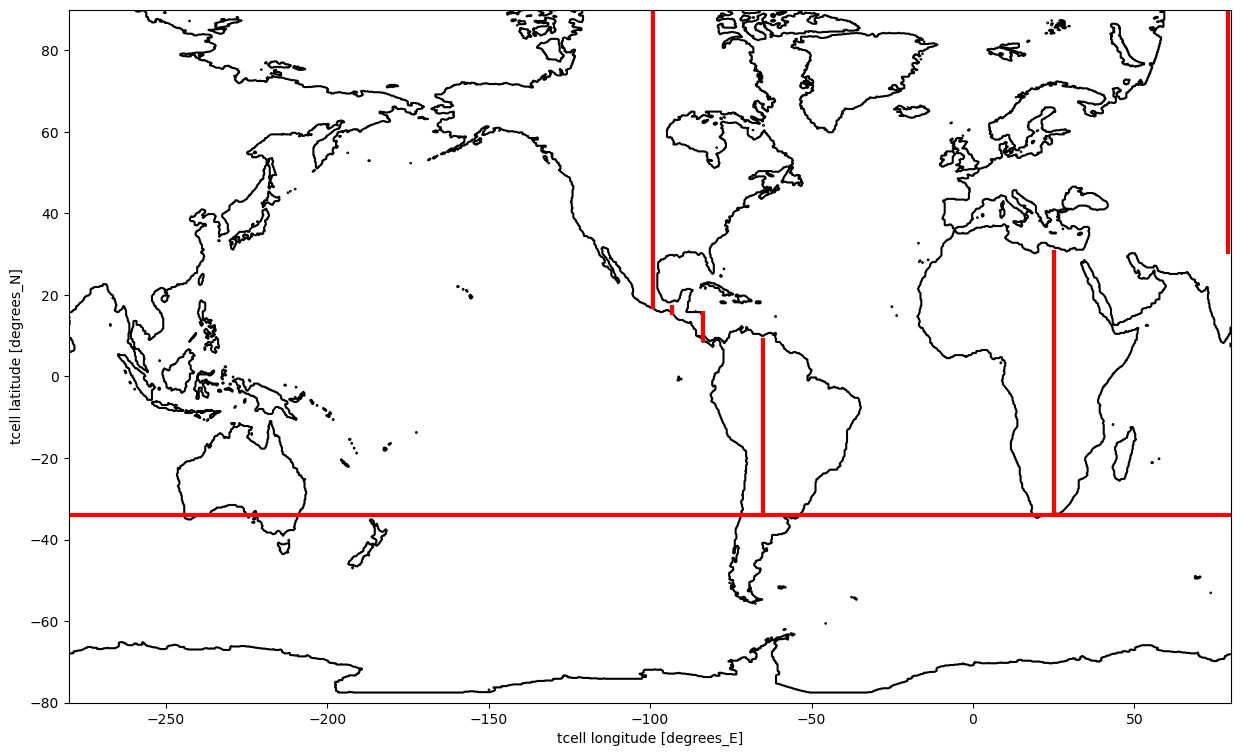

In [7]:
fig=plt.figure(2, (15, 9))
ax = plt.subplot()

land_mask.plot.contour(levels=[0.5], colors='k')

ax.plot([-280, 80], [-34,-34], 'r', linewidth = 3)
ax.plot([-65, -65], [-34, 9], 'r', linewidth = 3)
ax.plot([-83.7, -83.7], [9, 15.5], 'r', linewidth = 3)
ax.plot([-93.3, -93.3], [15.5, 17], 'r', linewidth = 3)
ax.plot([-99, -99], [17, 90], 'r', linewidth = 3)
ax.plot([25, 25], [-34,30.5], 'r', linewidth = 3)
ax.plot([79, 79], [30.5, 90], 'r', linewidth = 3)

ax.set_xlim([-280, 80])
ax.set_ylim([-80, 90]);

Now, let's make our masks along these dividing lines. Note that we include the Southern Ocean in both the Atlantic and the Indo-Pacific masks.

In [8]:
## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0)
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -65)).fillna(0)
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -83.7)).fillna(0)
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -93.3)).fillna(0)
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean > -280).where(land_mask.xt_ocean < -99)).fillna(0)
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean > 25).where(land_mask.xt_ocean < 80)).fillna(0)

indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)

atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map > 0)

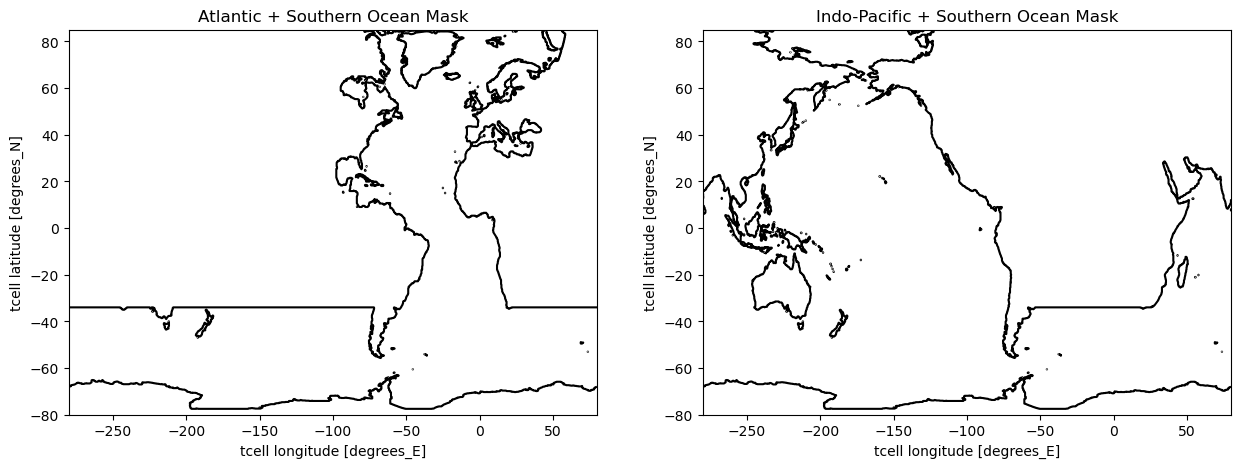

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

atlantic_sector_map.plot.contour(ax=ax[0], levels=[0.5], colors='k')
ax[0].set_xlim([-280, 80])
ax[0].set_ylim([-80, 85])
ax[0].set_title('Atlantic + Southern Ocean Mask')

indo_sector_map.plot.contour(ax=ax[1], levels=[0.5], colors='k')
ax[1].set_xlim([-280, 80])
ax[1].set_ylim([-80, 85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask');

## 3. Mask `ty_trans_rho` by the basins and compute basin MOC

The mask above is on a different grid `(yt_ocean, xt_ocean)` to `ty_trans_rho`, which uses `(yu_ocean, xt_ocean)`, so we'll need to alter that. This is done coarsely but we dont need a super perfect mask for this diagnostic. To do this, just load the a single frame of `ty_trans_rho` and replace the `yt_ocean` axes on our mask with `yu_ocean`.


In [10]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='ty_trans_rho')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['ty_trans_rho']
psi = darray ## needs to be the same coordinates as what you want to mask

atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean': 'grid_xt_ocean', 'yt_ocean': 'grid_yu_ocean'})

indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean': 'grid_xt_ocean', 'yt_ocean': 'grid_yu_ocean'})

var_list = var_search.df.variable[0]

Now write a function which calculates the time-averaged overturning circulation for a particular `basin_mask`. This function allows us to limit the time of the calculation using either `nbound` or `start_time` and `end_time`.

In [11]:
def compute_basin_psi_rho(experiment, varlist, basin_mask, nbound=None, start_time=None, end_time=None):
    rho = 1025 # mean density of sea-water in kg/m^3
    
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        print('GM is True')
        cat_subset = catalog[experiment]
        var_search = cat_subset.search(variable='ty_trans_rho_gm')
        darray = var_search.to_dask()
        darray = darray['ty_trans_rho_gm']
        darray = darray.sel(time=slice(start_time, end_time))
        psiGM = darray
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6 * rho)
    else:
        GM = False
        print('GM is False')
        
    cat_subset = catalog[experiment]
    var_search = cat_subset.search(variable='ty_trans_rho',frequency='1mon')
    darray = var_search.to_dask()
    darray = darray['ty_trans_rho']
    darray = darray.sel(time=slice(start_time, end_time))
    psi = darray      
    psi = psi / (1e6 * rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim='time').load() 
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

Now compute the basin-averaged, time-mean overturning for each basin.

**Note**: The following two cells might take a while! Like around 20min each.

In [12]:
%%time
atlantic_psi = compute_basin_psi_rho(experiment,var_list, atlantic_sector_mask, start_time=start_time, end_time=end_time)

GM is False
CPU times: user 1.16 s, sys: 65.2 ms, total: 1.23 s
Wall time: 1min 2s


In [13]:
%%time
indopacific_psi = compute_basin_psi_rho(experiment,var_list, indo_sector_mask, start_time=start_time, end_time=end_time)

GM is False
CPU times: user 935 ms, sys: 70.6 ms, total: 1.01 s
Wall time: 26.7 s


## 4. Plotting

Now plot the output.
I have chosen to do these plots with a distorted `y`-axis, so that you can see the densest water masses.

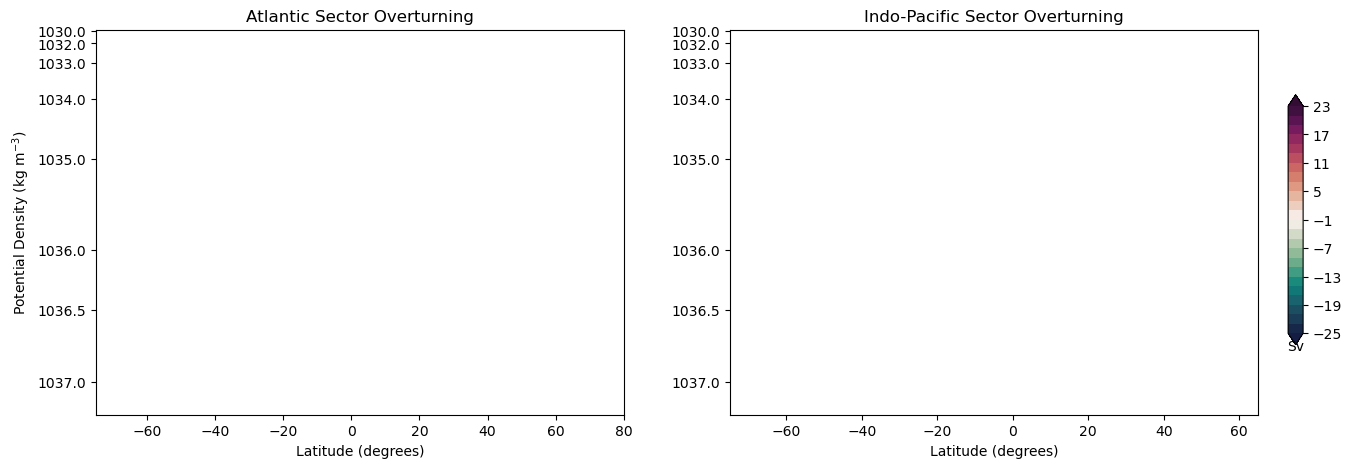

In [14]:
clev=np.arange(-25, 25, 2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036, 1036.5, 1037])
scfac = 4  ## A power to set the stretching of the y-axis

fig, ax=plt.subplots(1, 2, figsize=(15, 5))

## Plotting Atlantic Sector
ax[0].contourf(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
               cmap=cm.cm.curl, levels=clev, extend='both')
ax[0].contour(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
              levels=clev, colors='k', linewidths=0.25)
ax[0].contour(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho - 1028)**scfac, atlantic_psi,
              levels=[0.0,], colors='k', linewidths=0.75)

ax[0].set_yticks((yticks - 1028)**scfac)
ax[0].set_yticklabels(yticks)
ax[0].set_ylim([0.5**scfac, 9.2**scfac])
ax[0].invert_yaxis()
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude (degrees)')
ax[0].set_xlim([-75, 80])
ax[0].set_title('Atlantic Sector Overturning')


## Plotting Indo-Pacific Sector
p=ax[1].contourf(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
                 cmap=cm.cm.curl, levels=clev, extend='both')
ax[1].contour(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
              levels=clev, colors='k', linewidths=0.25)
ax[1].contour(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho - 1028)**scfac, indopacific_psi,
              levels=[0.0,], colors='k', linewidths=0.75)

ax[1].set_yticks((yticks - 1028)**scfac)
ax[1].set_yticklabels(yticks)
ax[1].set_ylim([0.5**scfac, 9.2**scfac])
ax[1].invert_yaxis()
ax[1].set_xlabel('Latitude (degrees)')
ax[1].set_xlim([-75, 65])
ax[1].set_title('Indo-Pacific Sector Overturning');

# Plot a colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p, cax=cax, orientation='vertical')
cb.ax.set_xlabel('Sv');

These plots compare pretty favourably with the ECCO4 reanalysis overturning cells (see Fig 2 of [Cessi, 2019](https://www.annualreviews.org/doi/full/10.1146/annurev-marine-010318-095241)). I think it adds something to the full zonally averaged picture.